### About

[Link to github repository](https://github.com/egp4aq/thomas-fire-analysis)

The Thomas Fire of December 2017 burned approximately 440 miles squared in Ventura and Santa Barbara counties. It was not fully contained until the the middle of January 2018. This fire had huge implications, as it displaced over 100,000 southern California residents, required the largest deployment of firefighters in California history to combat a wildfire, and cost over $200 million to fight.

To analyze the impact of the wildfire, we will look into the implications for air quality in the surrounding areas and how the vegetation was impacted using false color imagery.

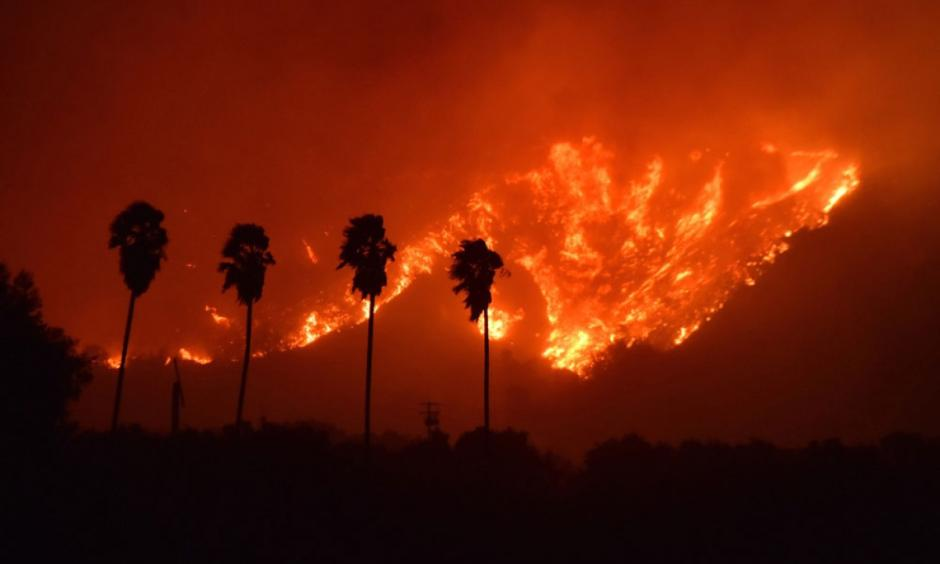

### Highlights of analysis

- Datetime analysis

- Rolling averages

- Manipulation of xarray data

- False color mapping

### Dataset Descriptions

1. Air Quality Index (AQI) data from the US Environmental Protection Agency

https://www.epa.gov/outdoor-air-quality-data

This dataset includes extensive information about air quality throughout the United States recorded by outdoor monitors.

2. Landsat Collection 2 Level-2 atmospherically collected surface reflectance data, collected by the Landsat 8 satellite 

https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

This collection of data includes landsat data from 1982 to the present day. 

3. California fire perimeter data from the US Department of the Interior

https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436

This catalog houses data about fire perimeters of all fires that have occurred in California.


## Air Quality Index data analysis

Before we do any analysis, our first step is always to read in our necessary libraries

In [1]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import xarray as xr
import rioxarray as rioxr

For the AQI data, we are going to read in the csv files directly from their url.

In [2]:
# Read in data from URL
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip", compression='zip')
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip", compression='zip')

Now we can do our analysis! This first part includes cleaning the aqi data, evaluating the rolling average, and plotting our results.

#### Combine and clean data
First, we bring together our dataframes from 2017 and 2018. Then we clean the column names by putting them all in lower snake case. Finally, we filter the data to only Santa Barbara and drop unnecessary columns.

In [3]:
# Use the concat() function to combine the two dataframes
aqi = pd.concat([aqi_17, aqi_18])

# Simplify column names
aqi.columns = (aqi.columns
                  .str.lower()
                  .str.replace(' ','_'))

# Filter to data only from Santa Barbara county
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']
# Drop state_name, county_name, state_code, and county_code columns from dataframe
aqi_sb = aqi_sb.drop(['state_name','county_name','state_code','county_code'], axis = 1)

#### Take rolling average of AQI data
Next, we put the date as the index of our dataframe so that we can use the index to take a rolling average over five days.

In [4]:
# Convert 'date' column to be of type datetime
aqi_sb.date = pd.to_datetime(aqi_sb.date)
aqi_sb = aqi_sb.set_index('date')

# Calculate AQI rolling average over 5 days
rolling_average = aqi_sb['aqi'].rolling(window = '5D').mean()

# Add a new column which includes the mean AQI for the 5 day rolling window 
aqi_sb['five_day_average'] = rolling_average

#### Plot
And now we can plot! We are going to plot the five day average over the total data.

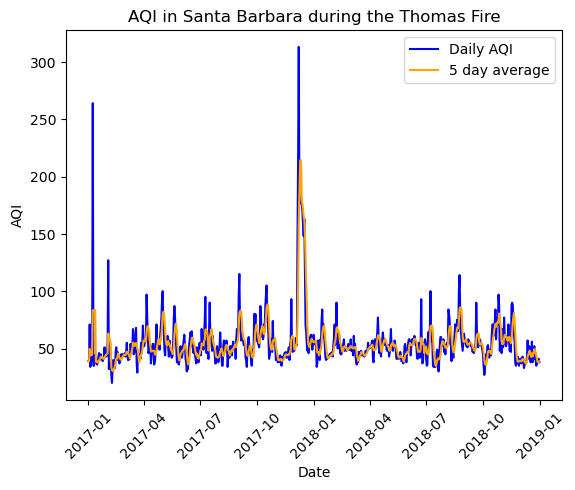

In [5]:
# Plot the data
plt.plot(aqi_sb.index.values, aqi_sb['aqi'], color = "blue")
plt.plot(aqi_sb.index.values, aqi_sb['five_day_average'], color = "orange")
plt.xticks(rotation=45)
plt.title("AQI in Santa Barbara during the Thomas Fire")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend(['Daily AQI', '5 day average'])

## False color mapping data analysis

For the next part of our analysis, we are going to use false color imagery to map the fire. To begin, we're going to read in all of our data, both the landsat and fire perimeter data.

In [6]:
# Import landsat data
fp = os.path.join('data','landsat8-2018-01-26-sb-simplified.nc')
landsat = rioxr.open_rasterio(fp)
# Read in thomas_boundary in this notebook from data folder
thomas_boundary = gpd.read_file('data/Thomas_Fire_boundary.shp')

We also want to make sure that our data are in the same format so that we can manipulate them. 

In [8]:
# Make sure that the thomas fire boundary and the landsat data are the same CRS
thomas_boundary = thomas_boundary.to_crs(landsat.rio.crs)
landsat.rio.crs == thomas_boundary.crs

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

Before we look into the landsat data, let's plot the Thomas fire boundary to see what it looks like.

In [ ]:
# Plot boundary to see what it looks like
thomas_boundary.plot()

First, we are going to drop the band dimension from the data and then select the desired variables.

In [ ]:
# Drop the band dimension from the data
landsat = landsat.squeeze("band", drop=True)

First, we make a true color image!

In [ ]:
# Use robust parameter to update scale for the plot
landsat[['red','green','blue']].to_array().plot.imshow(robust=True)

Now, we will create a false color image and layer on top the Thomas boundary!

In [ ]:
# Create a map with the false color image (like the one above) and the Thomas Fire perimeter
fig, ax = plt.subplots(figsize=(10,10))

landsat[['swir22','nir08','red']].to_array().plot.imshow(ax=ax, robust=True)

thomas_boundary.boundary.plot(ax=ax,
                    color="red")

ax.set_title("Thomas Fire (2017)")
ax.legend("Thomas Fire", loc = "upper left")

plt.show